# GP on aberrations:
- c1, a1x, a1y  full grid values are [-1, 1], [-1, 1] and [-1, 1]- say 10 in ech direction- total 1000 sets of 3
- Sample c1, a1x, a1y --> 20 seed points  in that range--> (c1_i, a1_i, a1y_i) for i in [1, 20]
- get haadf-image (512*512) for each  (c1_i, a1_i, a1y_i) for i in [1, 20]
- compute contrast: np.std(normalized_image_data) / np.average(normalized_image_data)
- train a GP on seed points
- infer GP on the entire data - 


Tips:
- How to handle cuda device etc- later 
- fastest way to simulate- later

### AH notebook is here - https://github.com/AustinHouston/pystemsim/blob/main/Ex_for_SmartTuning.ipynb

In [16]:
import numpy as np
def get_haadf(c1, a1x, a1y):
    image = np.array(512, 512)
    normalized_image_data = image - np.min(image)
    normalized_image_data = normalized_image_data / np.max(normalized_image_data)
    return normalized_image_data 


def get_contrast(normalized_image_data):
    contrast = np.std(normalized_image_data) / np.average(normalized_image_data)
    return contrast

In [17]:
# what is entire grid data for c1, a1x, a1y


# sample 20 seed points for c1x, a1x, a1y


# query haadf on th essed points and get score


# train gp on these seed points and score 

# plot results

## try1

In [18]:
import numpy as np
import torch
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [19]:
# Simulator functions
def get_haadf(c1, a1x, a1y):
    """Simulate HAADF image based on aberration parameters"""
    image = np.random.randn(512, 512)
    # Simulate effect of aberrations (lower aberrations = higher contrast)
    aberration_effect = np.exp(-2 * (c1**2 + a1x**2 + a1y**2))
    image = image * (1 + aberration_effect * 5)
    
    normalized_image_data = image - np.min(image)
    normalized_image_data = normalized_image_data / np.max(normalized_image_data)
    return normalized_image_data

def get_contrast(normalized_image_data):
    """Calculate contrast metric"""
    contrast = np.std(normalized_image_data) / np.mean(normalized_image_data)
    return contrast

In [20]:
# Create full grid
n_grid = 10
c1_grid = np.linspace(-1, 1, n_grid)
a1x_grid = np.linspace(-1, 1, n_grid)
a1y_grid = np.linspace(-1, 1, n_grid)
C1, A1X, A1Y = np.meshgrid(c1_grid, a1x_grid, a1y_grid, indexing='ij')
full_grid = np.stack([C1.flatten(), A1X.flatten(), A1Y.flatten()], axis=1)


In [21]:
# Sample 20 seed points
n_seed = 20
seed_indices = np.random.choice(len(full_grid), n_seed, replace=False)
seed_points = full_grid[seed_indices]

In [22]:
# Query HAADF and compute contrast for seed points
print("Computing contrast for seed points...")
seed_scores = []
for i, (c1, a1x, a1y) in enumerate(seed_points):
    image = get_haadf(c1, a1x, a1y)
    contrast = get_contrast(image)
    seed_scores.append(contrast)
    print(f"Seed {i+1}/{n_seed}: c1={c1:.2f}, a1x={a1x:.2f}, a1y={a1y:.2f}, contrast={contrast:.4f}")

seed_scores = np.array(seed_scores)

# Convert to PyTorch tensors
train_X = torch.tensor(seed_points, dtype=torch.float64)
train_Y = torch.tensor(seed_scores, dtype=torch.float64).unsqueeze(-1)


Computing contrast for seed points...
Seed 1/20: c1=0.11, a1x=-0.56, a1y=-0.78, contrast=0.2236
Seed 2/20: c1=0.56, a1x=-0.33, a1y=0.56, contrast=0.2330
Seed 3/20: c1=0.56, a1x=-0.11, a1y=-1.00, contrast=0.2274
Seed 4/20: c1=0.33, a1x=0.33, a1y=-1.00, contrast=0.2119
Seed 5/20: c1=-0.11, a1x=-0.78, a1y=-0.78, contrast=0.2115
Seed 6/20: c1=0.33, a1x=0.56, a1y=0.78, contrast=0.2134
Seed 7/20: c1=0.33, a1x=-0.56, a1y=0.33, contrast=0.2041
Seed 8/20: c1=0.11, a1x=-0.78, a1y=-0.33, contrast=0.2285
Seed 9/20: c1=0.78, a1x=0.11, a1y=1.00, contrast=0.2176
Seed 10/20: c1=-0.78, a1x=-0.33, a1y=0.33, contrast=0.2336
Seed 11/20: c1=0.78, a1x=-0.78, a1y=-0.78, contrast=0.2268
Seed 12/20: c1=-1.00, a1x=0.56, a1y=0.33, contrast=0.2338
Seed 13/20: c1=0.33, a1x=-0.33, a1y=0.33, contrast=0.2216
Seed 14/20: c1=1.00, a1x=0.56, a1y=-0.33, contrast=0.2164
Seed 15/20: c1=1.00, a1x=-0.33, a1y=0.78, contrast=0.2232
Seed 16/20: c1=0.78, a1x=1.00, a1y=1.00, contrast=0.2229
Seed 17/20: c1=-0.56, a1x=0.78, a1y=-1.

In [23]:
# Train GP
print("\nTraining GP model...")
gp_model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)


Training GP model...


/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [24]:
# Predict on full grid
print("Making predictions on full grid...")
test_X = torch.tensor(full_grid, dtype=torch.float64)
gp_model.eval()
with torch.no_grad():
    posterior = gp_model.posterior(test_X)
    predictions = posterior.mean.numpy().flatten()
    uncertainties = posterior.variance.sqrt().numpy().flatten()


Making predictions on full grid...


In [25]:
# Find best predicted point
best_idx = np.argmax(predictions)
best_params = full_grid[best_idx]
print(f"\nBest predicted point: c1={best_params[0]:.2f}, a1x={best_params[1]:.2f}, a1y={best_params[2]:.2f}")
print(f"Predicted contrast: {predictions[best_idx]:.4f}")


Best predicted point: c1=-0.33, a1x=-0.78, a1y=1.00
Predicted contrast: 0.2377


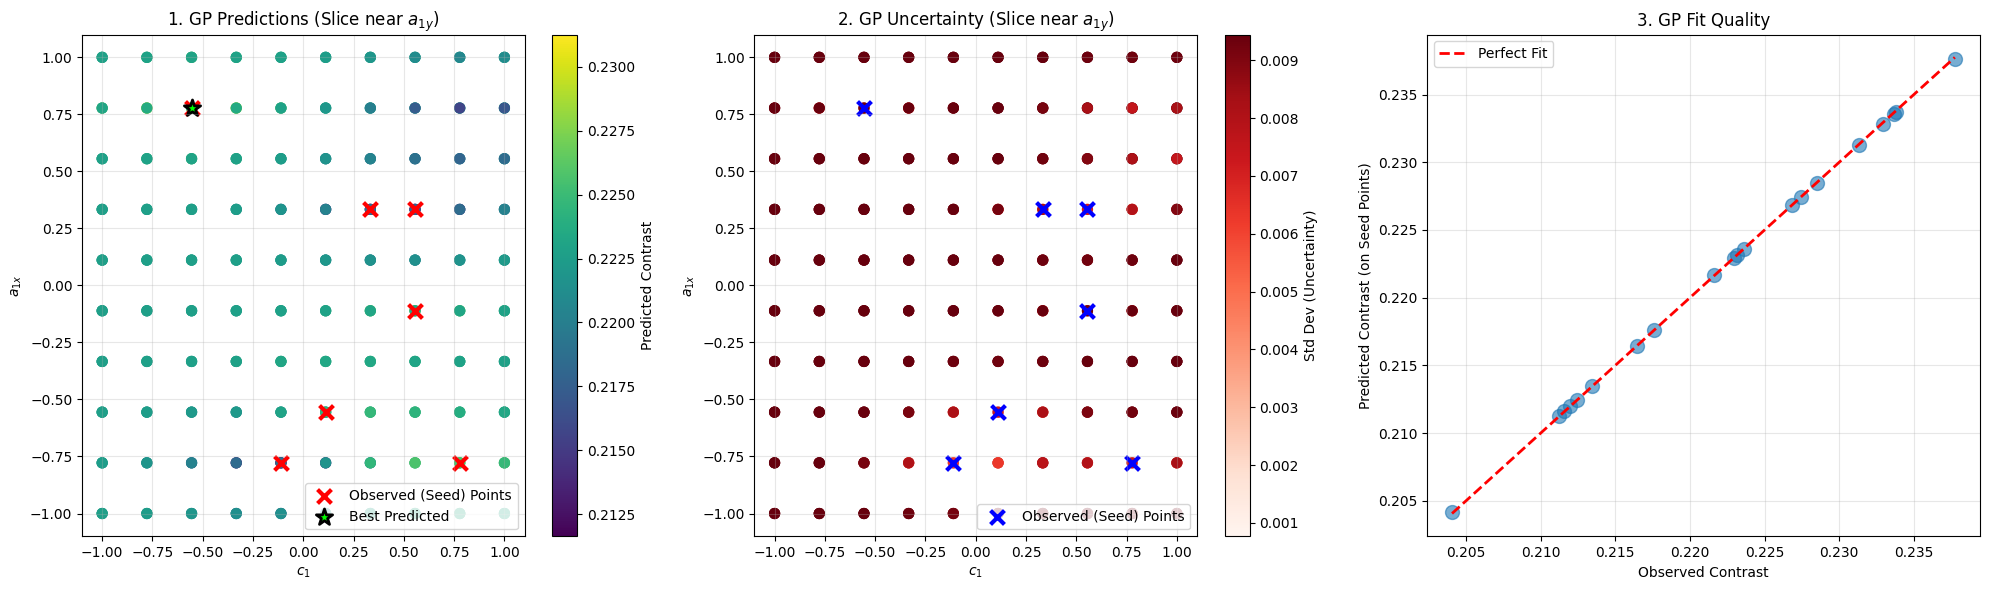

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- New Minimal Plotting ---

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define a tight slice for visualization (a1y close to 0)
# Note: The logic for slice_mask, slice_grid, etc., remains similar to your original code
slice_mask = np.abs(full_grid[:, 2] - full_grid[:, 2].min()) < 0.5
slice_grid = full_grid[slice_mask]
slice_pred = predictions[slice_mask]
slice_unc = uncertainties[slice_mask]
seed_mask = np.abs(seed_points[:, 2] - seed_points[:, 2].min()) < 0.5

# --- Plot 1: GP Predictions (slice) ---
ax = axes[0]
scatter1 = ax.scatter(slice_grid[:, 0], slice_grid[:, 1],
                       c=slice_pred, cmap='viridis', s=50)
ax.scatter(seed_points[seed_mask, 0], seed_points[seed_mask, 1],
            c='red', s=100, marker='x', linewidths=3, label='Observed (Seed) Points')

# Find the best predicted point within the slice for plotting (if available)
best_in_slice = slice_grid[np.argmax(slice_pred)]
ax.scatter(best_in_slice[0], best_in_slice[1],
            c='lime', s=150, marker='*', edgecolors='black', linewidths=2, label='Best Predicted')

ax.set_xlabel('$c_1$')
ax.set_ylabel('$a_{1x}$')
ax.set_title('1. GP Predictions (Slice near $a_{1y}$)')
plt.colorbar(scatter1, ax=ax, label='Predicted Contrast')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)


# --- Plot 2: GP Uncertainty (slice) ---
ax = axes[1]
scatter2 = ax.scatter(slice_grid[:, 0], slice_grid[:, 1],
                       c=slice_unc, cmap='Reds', s=50)
ax.scatter(seed_points[seed_mask, 0], seed_points[seed_mask, 1],
            c='blue', s=100, marker='x', linewidths=3, label='Observed (Seed) Points')
ax.set_xlabel('$c_1$')
ax.set_ylabel('$a_{1x}$')
ax.set_title('2. GP Uncertainty (Slice near $a_{1y}$)')
plt.colorbar(scatter2, ax=ax, label='Std Dev (Uncertainty)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# --- Plot 3: GP Fit Quality (Observed vs Predicted) ---
# Assuming 'seed_predictions' is calculated as the GP mean on the training data
ax = axes[2]
ax.scatter(seed_scores, seed_predictions, s=100, alpha=0.6)
# Plot the y=x line
score_min = min(seed_scores.min(), seed_predictions.min())
score_max = max(seed_scores.max(), seed_predictions.max())
ax.plot([score_min, score_max],
        [score_min, score_max], 'r--', lw=2, label='Perfect Fit')
ax.set_xlabel('Observed Contrast')
ax.set_ylabel('Predicted Contrast (on Seed Points)')
ax.set_title('3. GP Fit Quality')
ax.grid(True, alpha=0.3)
ax.legend()


# plt.suptitle('Bayesian Optimization Analysis (Minimal View)', fontsize=16, y=1.03)
plt.tight_layout()
# plt.savefig('bo_minimal_analysis_dummy.png', dpi=150, bbox_inches='tight')